In [74]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
df = pd.read_csv('../data/yellow_tripdata_2017-01_subset10000rows.csv')
# imagine this is our population distribution
trip_distance = df.trip_distance.dropna().iloc[:1000]

In [3]:
np.random.seed(123)

n = 50 # sample size

# take a sample from the population
sample_idx = np.random.permutation(len(trip_distance))[:n]

sample = trip_distance.iloc[sample_idx]
sample.describe()

count    50.000000
mean      2.290800
std       2.596723
min       0.370000
25%       0.825000
50%       1.450000
75%       2.550000
max      13.100000
Name: trip_distance, dtype: float64

In [4]:
sample = trip_distance.sample(n, random_state=123)
sample.describe()

count    50.000000
mean      2.290800
std       2.596723
min       0.370000
25%       0.825000
50%       1.450000
75%       2.550000
max      13.100000
Name: trip_distance, dtype: float64

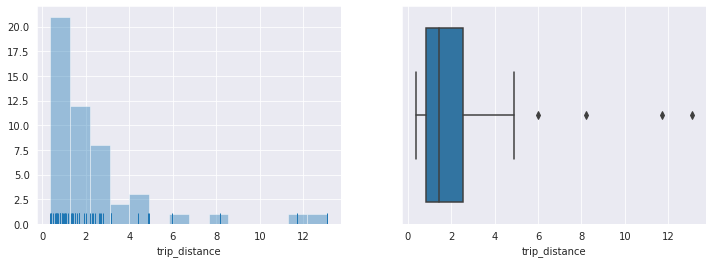

In [5]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(sample, kde=False, rug=True, ax=ax[0]);
sns.boxplot(sample, ax=ax[1]);

plt.savefig('../slides/eods-04-hypothesistesting/images/tripdistance_distplot.png')

In [6]:
xbar = sample.mean()
print(f'sample mean: {xbar:0.2f}')

sample mean: 2.29


In [7]:
sample_means = []
for i in range(1000):
    sample_mean = trip_distance.sample(n,random_state=i).mean()
    sample_means.append(sample_mean)

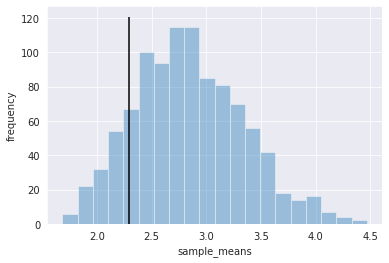

In [8]:
ax = sns.distplot(sample_means, kde=False)
ax.set_xlabel('sample_means');
ax.set_ylabel('frequency');
ax.vlines(xbar,*ax.get_ylim());

plt.savefig('../slides/eods-04-hypothesistesting/images/tripdistance_samplemeans_distplot.png')

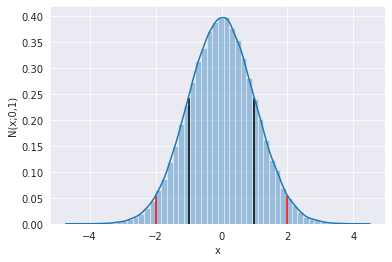

In [9]:
import scipy as sp

x = np.random.normal(0,1,size=100000)
ax = sns.distplot(x);
ax.set_xlabel('x');ax.set_ylabel('N(x;0,1)')
ax.vlines([-1,1],0,sp.stats.norm.pdf(1), colors='k');
ax.vlines([-2,2],0,sp.stats.norm.pdf(2), colors='r');

plt.savefig('../slides/eods-04-hypothesistesting/images/normal_distplot.png')

In [10]:
n = len(trip_distance)
n

1000

In [11]:
x_bar = trip_distance.mean()
print(f'sample mean: {x_bar:0.4f}')

sample mean: 2.8324


In [12]:
def generate_bootstrap(X, n=None, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n = len(X) if n is None else n
    return np.random.choice(X,n,replace=True)

In [13]:
generate_bootstrap(trip_distance,3,random_state=123)

array([1.6 , 0.56, 0.44])

In [14]:
trip_distance.sample(3,replace=True,random_state=123) # using pandas

510    1.60
365    0.56
382    0.44
Name: trip_distance, dtype: float64

In [15]:
try:
    trip_distance.sample(len(trip_distance)+1,replace=False,random_state=123)
except ValueError as e:
    print(e)

Cannot take a larger sample than population when 'replace=False'


In [16]:
# 3. repeat 1 and 2 many times
num_iterations = 1000
bootstrap_means = []
for i in range(num_iterations):
    # 1. draw a random sample of size *n* from the data
    bootstrap = generate_bootstrap(trip_distance.values,random_state=i)
    # 2. record the sample statistic from this random sample
    bootstrap_means.append(np.mean(bootstrap))
bootstrap_means = np.array(bootstrap_means)

In [17]:
trim = .5*(1-.95) * num_iterations
trim

25.00000000000002

In [18]:
trim = int(np.round(trim))
trim

25

In [19]:
# 5. those trim points are the endpoints of the the  alpha%  bootstrap conf int
ci = np.sort(bootstrap_means)[[trim,-trim]] # sort the array!
ci

array([2.62998, 3.08587])

In [20]:
assert len(bootstrap_means[trim:-trim])+len(bootstrap_means[:trim])+len(bootstrap_means[-trim:]) == num_iterations

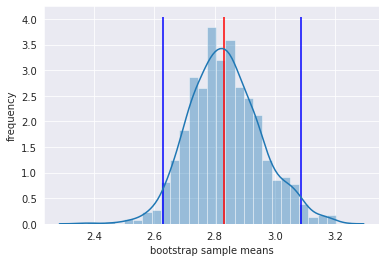

In [21]:
ax = sns.distplot(bootstrap_means)
ylim = ax.get_ylim()
ax.vlines(trip_distance.mean(), *ylim, color='r');
ax.vlines(ci, *ylim, color='b')
ax.set_xlabel('bootstrap sample means');
ax.set_ylabel('frequency');

plt.savefig('../slides/eods-04-hypothesistesting/images/tripdistance_bootstrap_distplot_withconfints.png')

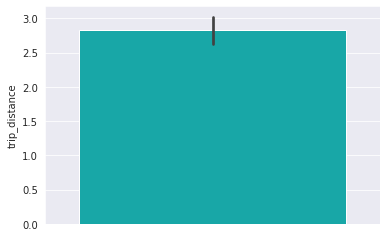

In [24]:
sns.barplot(trip_distance,
            estimator=np.mean, #default
            ci=95,             #default
            n_boot=100,        #default
            orient='v',
            color='c',
           );

plt.savefig('../slides/eods-04-hypothesistesting/images/tripdistance_bootstrap_bar_withconfints.png')

In [27]:
session_times = pd.read_csv('../data/web_page_data.csv')
session_times.shape

(36, 2)

In [28]:
session_times.head(3)

,Page,Time
0,Page A,12.6
1,Page B,151.8
2,Page A,21.0


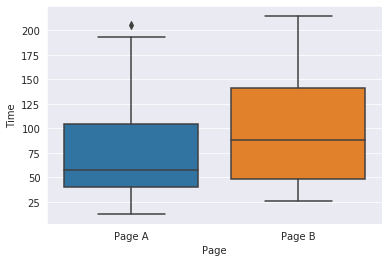

In [29]:
sns.boxplot(x='Page',y='Time',data=session_times);

plt.savefig('../slides/eods-04-hypothesistesting/images/pagetime_boxplots.png')

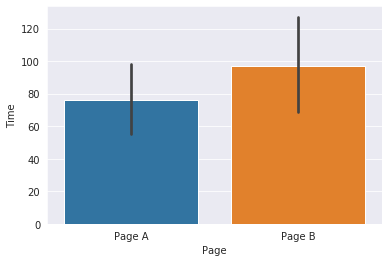

In [30]:
sns.barplot(x='Page',y='Time',data=session_times);

plt.savefig('../slides/eods-04-hypothesistesting/images/pagetime_bar.png')

In [31]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
observed_metric = mean_b-mean_a
print('observed metric: {:0.2f}'.format(observed_metric))

observed metric: 21.40


In [43]:
n_a = sum(session_times.Page == 'Page A')
n_b = sum(session_times.Page == 'Page B')
n = n_a + n_b

In [44]:
samples = session_times.Time

In [46]:
permuted = session_times.Time.sample(n,replace=False,random_state=123)

In [47]:
rand_mean_a = permuted[:n_a].mean()
rand_mean_b = permuted[n_a:].mean()
rand_mean_diff = (rand_mean_b - rand_mean_a)
print('{:.2f}'.format(rand_mean_diff))

-17.41


In [52]:
rand_mean_diffs = []
for i in range(10000):
    permuted = session_times.Time.sample(n,replace=False,random_state=i)
    rand_mean_a = permuted[:n_a].mean()
    rand_mean_b = permuted[n_a:].mean()
    rand_mean_diffs.append(rand_mean_b - rand_mean_a)
rand_mean_diffs[:10]

[16.257142857142853,
 16.874285714285705,
 10.291428571428597,
 -31.811428571428564,
 10.565714285714321,
 -6.508571428571415,
 12.48571428571428,
 -7.605714285714299,
 -16.794285714285706,
 -6.577142857142874]

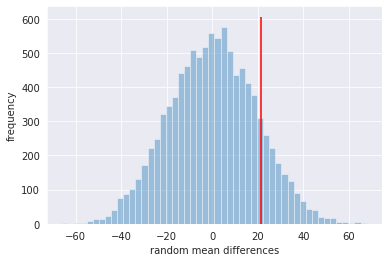

In [54]:
ax = sns.distplot(rand_mean_diffs, norm_hist=False, kde=False)
ax.set_xlabel('random mean differences');ax.set_ylabel('frequency');
ax.vlines(observed_metric, *ax.get_ylim(), color='r');

plt.savefig('../slides/eods-04-hypothesistesting/images/pagetime_permutation_test.png')

In [58]:
xbar = np.mean(rand_mean_diffs)
s = np.std(rand_mean_diffs)

rand_zscores = (rand_mean_diffs - xbar) / s

observed_metric_zscore =  (observed_metric - xbar) / s

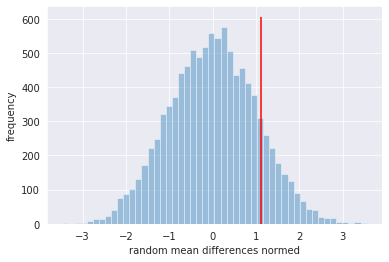

In [59]:
ax = sns.distplot(rand_zscores, norm_hist=False, kde=False)
ax.set_xlabel('random mean differences normed');ax.set_ylabel('frequency');
ax.vlines(observed_metric_zscore, *ax.get_ylim(), color='r');

plt.savefig('../slides/eods-04-hypothesistesting/images/pagetime_permutation_test_normed.png')

In [60]:
gt = np.abs(np.array(rand_mean_diffs)) >= np.abs(observed_metric)

In [63]:
# how many are greater?
num_gt = gt.sum()

In [64]:
p = num_gt / len(rand_mean_diffs)
p

0.2655

In [65]:
sum(np.array(rand_mean_diffs) >= observed_metric) / len(rand_mean_diffs)

0.1328

In [66]:
df = pd.DataFrame({'Price A':[200,23539],
                   'Price B':[182,22406]},
                   index=['Conversion','No Conversion'])
df

,Price A,Price B
Conversion,200,182
No Conversion,23539,22406


In [67]:
pct_conv = df.loc['Conversion'] / df.sum(axis=0) * 100
pct_conv

Price A    0.842495
Price B    0.805738
dtype: float64

In [68]:
diff_pct_conv = pct_conv['Price A'] - pct_conv['Price B']
print(f'{diff_pct_conv:.4f}%')

0.0368%


In [69]:
n = df.sum().sum()
n

46327

In [70]:
n_conversion = df.loc['Conversion'].sum()
n_conversion

382

In [71]:
samples = np.zeros(n)
samples[:n_conversion] = 1  
assert sum(samples) == n_conversion

In [72]:
n_a, n_b = df.sum(axis=0)
print(n_a, n_b, n_a + n_b)
assert n_a + n_b == n

23739 22588 46327


In [76]:
%%time
rand_conv_diffs = []
np.random.seed(123)
for i in tqdm.tqdm(range(1000)):
    permutation = np.random.permutation(samples)
    rand_conv_a = sum(permutation[:n_a]) / n_a
    rand_conv_b = sum(permutation[n_a:]) / n_b
    rand_conv_diffs.append(100 * (rand_conv_a - rand_conv_b))

100%|██████████| 1000/1000 [00:06<00:00, 159.24it/s]

CPU times: user 6.3 s, sys: 0 ns, total: 6.3 s
Wall time: 6.28 s


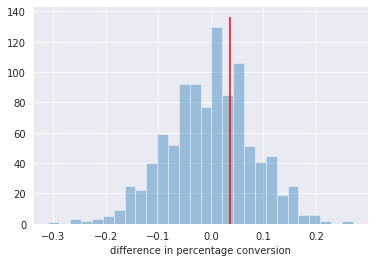

In [79]:
ax = sns.distplot(rand_conv_diffs, norm_hist=False, kde=False)
ax.vlines(diff_pct_conv, *ax.get_ylim(), color='r');
ax.set_xlabel('difference in percentage conversion')

plt.savefig('../slides/eods-04-hypothesistesting/images/conversion_permutation_distplot.png')

In [80]:
( sum(np.abs(np.array(rand_conv_diffs)) >= np.abs(diff_pct_conv))
    / len(rand_conv_diffs) )

0.663

In [88]:
from statsmodels.stats.proportion import proportions_ztest

z,p = proportions_ztest(df.loc['Conversion'].values,
                        df.sum(),
                        alternative='two-sided')
p

0.6618881488312065

In [300]:
# creating two ads (distributions) with unknown response rate
np.random.seed(13)
ad_A = sp.stats.bernoulli(p=np.random.rand())
ad_B = sp.stats.bernoulli(p=np.random.rand())

In [301]:
# epsilon probability
epsilon = 0.40

In [302]:
pulls_A = [ad_A.rvs()]
pulls_B = [ad_B.rvs()]

In [303]:
pulls_A,pulls_B

([0], [1])

In [304]:
be_greedy = np.random.rand() > epsilon
be_greedy

True

In [305]:
pulls_B.append(ad_B.rvs())
pulls_A,pulls_B

([0], [1, 0])

In [306]:
def mab(ad_A,ad_B,pulls_A,pulls_B,epsilon):
    be_greedy = np.random.rand() > epsilon
    if not be_greedy: # randomly choose
        if np.random.rand() < 0.5:
            pulls_A.append(ad_A.rvs())
            choice = 'A'
        else:
            pulls_B.append(ad_B.rvs())
            choice = 'B'
    else: # be greedy
        resp_A = sum(pulls_A) / len(pulls_A)
        resp_B = sum(pulls_B) / len(pulls_B)
        if resp_A > resp_B:
            pulls_A.append(ad_A.rvs())
            choice = 'A'
        else:
            pulls_B.append(ad_B.rvs())
            choice = 'B'
    return pulls_A, pulls_B, be_greedy, choice

In [307]:
pulls_A, pulls_B, be_greedy, choice = mab(ad_A,
                                          ad_B,
                                          pulls_A,
                                          pulls_B,
                                          epsilon)
print(f'{str(be_greedy):5s} {choice} => '+
      f'{np.mean(pulls_A):0.2f}:{np.mean(pulls_B):0.2f}  '+
      f'{str(pulls_A):20s}, {str(pulls_B):20s}')

True  B => 0.00:0.67  [0]                 , [1, 0, 1]           


In [308]:
for i in range(10):
    pulls_A, pulls_B, be_greedy, choice = mab(ad_A,ad_B,pulls_A,pulls_B,epsilon)
    print(f'{str(be_greedy):5s} {choice} => '+
          f'{np.mean(pulls_A):0.2f}:{np.mean(pulls_B):0.2f} {str(pulls_A):20s}, {str(pulls_B):20s}')

True  B => 0.00:0.50  [0]                 , [1, 0, 1, 0]        
False A => 0.50:0.50  [0, 1]              , [1, 0, 1, 0]        
True  B => 0.50:0.40  [0, 1]              , [1, 0, 1, 0, 0]     
True  A => 0.67:0.40  [0, 1, 1]           , [1, 0, 1, 0, 0]     
False A => 0.75:0.40  [0, 1, 1, 1]        , [1, 0, 1, 0, 0]     
True  A => 0.80:0.40  [0, 1, 1, 1, 1]     , [1, 0, 1, 0, 0]     
False B => 0.80:0.33  [0, 1, 1, 1, 1]     , [1, 0, 1, 0, 0, 0]  
False B => 0.80:0.43  [0, 1, 1, 1, 1]     , [1, 0, 1, 0, 0, 0, 1]
False B => 0.80:0.50  [0, 1, 1, 1, 1]     , [1, 0, 1, 0, 0, 0, 1, 1]
False B => 0.80:0.44  [0, 1, 1, 1, 1]     , [1, 0, 1, 0, 0, 0, 1, 1, 0]


In [309]:
print(f'conversion rates: A: {np.mean(pulls_A):0.2f} B: {np.mean(pulls_B):0.2f}')

conversion rates: A: 0.80 B: 0.44


In [310]:
print(f'ground truth: A: {ad_A.pmf(1):0.2f} B: {ad_B.pmf(1):0.2f}')

ground truth: A: 0.78 B: 0.24
